<a href="https://colab.research.google.com/github/minghao51/STForecast/blob/master/tf_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [446]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [447]:
df = pd.read_csv('daily.csv')
df.head()

,Date,Count
0,1999-07-01,0.0
1,1999-07-02,0.0
2,1999-07-03,0.0
3,1999-07-04,0.0
4,1999-07-05,0.0


In [448]:
df = pd.read_csv('daily.csv')
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date'))

# Time (Periodicity)

For monthly and yearly periodicity. 

A simple approach to convert it to a usable signal is to use sin and cos to convert the time to clear "Time of month" and "Time of year" signals:

In [449]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [450]:
# day = 24*60*60
# month = (29.53)*29
# year = (365.2425)*day


# df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
# df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))

# df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
# df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [451]:
# df.head()

In [452]:
# plt.plot(np.array(df['Month sin'])[:25])
# plt.plot(np.array(df['Month cos'])[:25])
# plt.xlabel('Time [h]')
# plt.title('Time of day signal')

Using fft to check whether the periodicity of month and year are significant (our assumptions), here is the tf.signal.rfft of the temperature over time. 

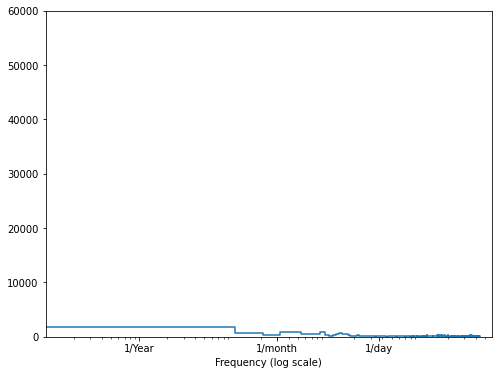

In [453]:
fft = tf.signal.rfft(df['Count'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['Count'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 60000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 29.53, 365.2524], labels=['1/Year', '1/month','1/day'])
_ = plt.xlabel('Frequency (log scale)')

Hence it looks like there is some periodicty on a monthly, daily and yearly overtime.

# Splitting the data
We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [546]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [547]:
len(test_df)

83

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

In [548]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

# Data Windowing

In [456]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [457]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Count'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Count']

In [458]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [459]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
labels shape: (3, 1, 1)


# Visualizing splitting windows

In [460]:
w2.example = example_inputs, example_labels

In [461]:
def plot(self, model=None, plot_col='Count', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Days')

WindowGenerator.plot = plot

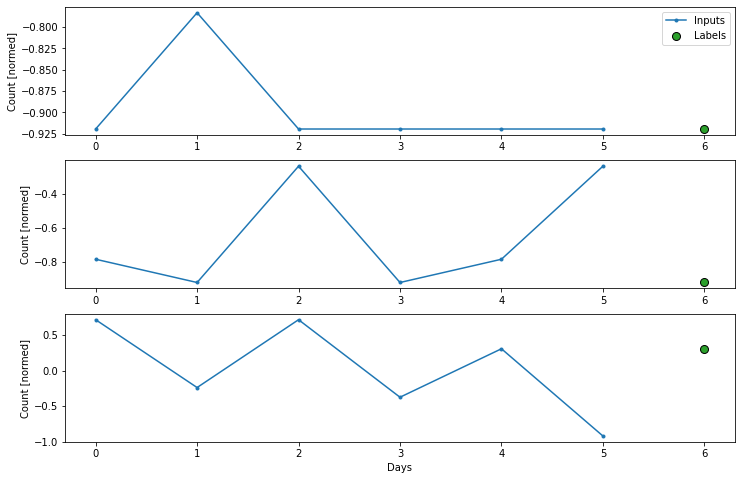

In [462]:
w2.plot()

In [463]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [464]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [465]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [466]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [467]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Count'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Count']

# Baseline

In [468]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [469]:
baseline = Baseline(label_index=column_indices['Count'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()
                          ])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

6/6 [==============================] - 0s 1ms/step - loss: 0.4404 - mean_absolute_error: 0.5317


In [470]:
wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=1,
    label_columns=['Count'])

wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['Count']

In [471]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 1)
Output shape: (32, 1, 1)


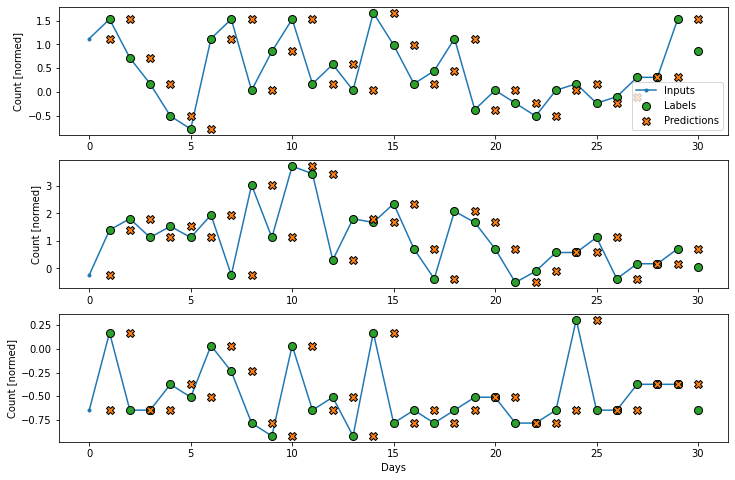

In [472]:
wide_window.plot(baseline)

# Linear

In [473]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [474]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 1)
Output shape: (32, 1, 1)


In [475]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [445]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
18/18 [==============================] - 0s 11ms/step - loss: 1.0143 - mean_absolute_error: 0.6579 - val_loss: 0.5359 - val_mean_absolute_error: 0.5852
Epoch 2/20
18/18 [==============================] - 0s 5ms/step - loss: 0.9946 - mean_absolute_error: 0.6493 - val_loss: 0.5270 - val_mean_absolute_error: 0.5803
Epoch 3/20
18/18 [==============================] - 0s 6ms/step - loss: 0.9764 - mean_absolute_error: 0.6420 - val_loss: 0.5184 - val_mean_absolute_error: 0.5758
Epoch 4/20
18/18 [==============================] - 0s 5ms/step - loss: 0.9598 - mean_absolute_error: 0.6350 - val_loss: 0.5099 - val_mean_absolute_error: 0.5714
Epoch 5/20
18/18 [==============================] - 0s 6ms/step - loss: 0.9428 - mean_absolute_error: 0.6281 - val_loss: 0.5020 - val_mean_absolute_error: 0.5672
Epoch 6/20
18/18 [==============================] - 0s 5ms/step - loss: 0.9267 - mean_absolute_error: 0.6213 - val_loss: 0.4945 - val_mean_absolute_error: 0.5631
Epoch 7/20
18/18 [=========

In [476]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 30, 1)
Output shape: (32, 30, 1)


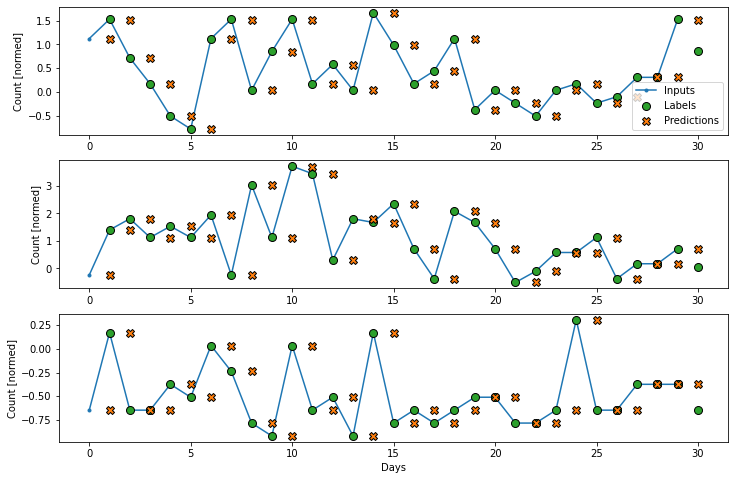

In [477]:
wide_window.plot(linear)

In [478]:
# plt.bar(x = range(len(train_df.columns)),
#         height=linear.layers[0].kernel[:,0].numpy())
# axis = plt.gca()
# axis.set_xticks(range(len(train_df.columns)))
# _ = axis.set_xticklabels(train_df.columns, rotation=90)

# CNN

In [479]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
18/18 [==============================] - 0s 13ms/step - loss: 0.7368 - mean_absolute_error: 0.6067 - val_loss: 0.3259 - val_mean_absolute_error: 0.4706
Epoch 2/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6509 - mean_absolute_error: 0.5444 - val_loss: 0.3392 - val_mean_absolute_error: 0.4796
Epoch 3/20
6/6 [==============================] - 0s 2ms/step - loss: 0.3285 - mean_absolute_error: 0.4744


In [480]:
CONV_WIDTH = 30
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Count'])

conv_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Count']

Text(0.5, 1.0, 'Given 6days as input, predict 1 days into the future.')

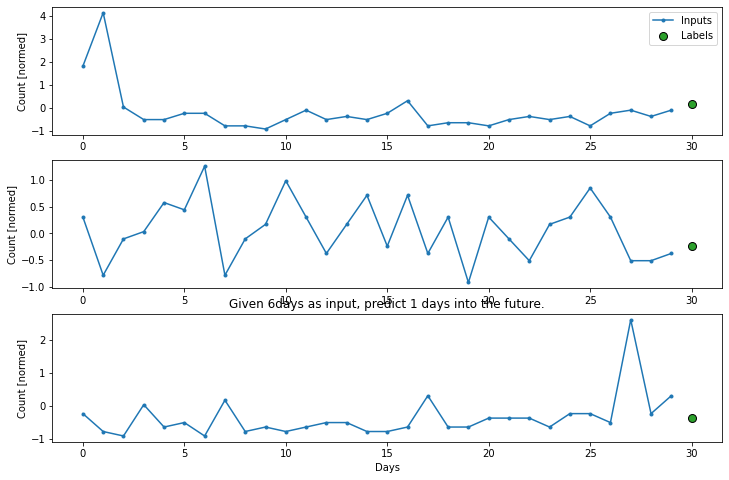

In [481]:
conv_window.plot()
plt.title("Given 6days as input, predict 1 days into the future.")

# Multi Step Dense

In [482]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [483]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 30, 1)
Output shape: (32, 1, 1)


In [484]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

5/5 [==============================] - 0s 1ms/step - loss: 0.2776 - mean_absolute_error: 0.4214


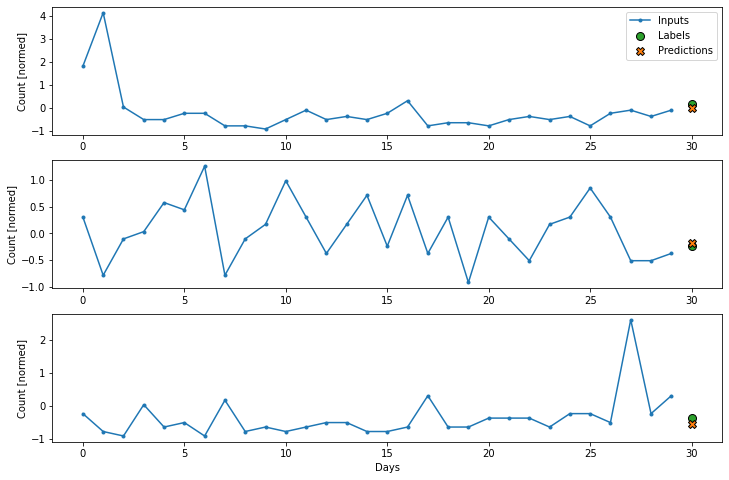

In [485]:
conv_window.plot(multi_step_dense)

In [486]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 30, 1)
Output shape: (32, 1, 1)


# Conv

In [487]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [488]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 30, 1)
Output shape: (32, 1, 1)


In [489]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

5/5 [==============================] - 0s 2ms/step - loss: 0.2730 - mean_absolute_error: 0.4246


In [490]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 30, 1)
Labels shape: (32, 30, 1)
Output shape: (32, 1, 1)


In [491]:
LABEL_WIDTH = 12
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Count'])

wide_conv_window

Total window size: 42
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41]
Label column name(s): ['Count']

In [492]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 41, 1)
Labels shape: (32, 12, 1)
Output shape: (32, 12, 1)


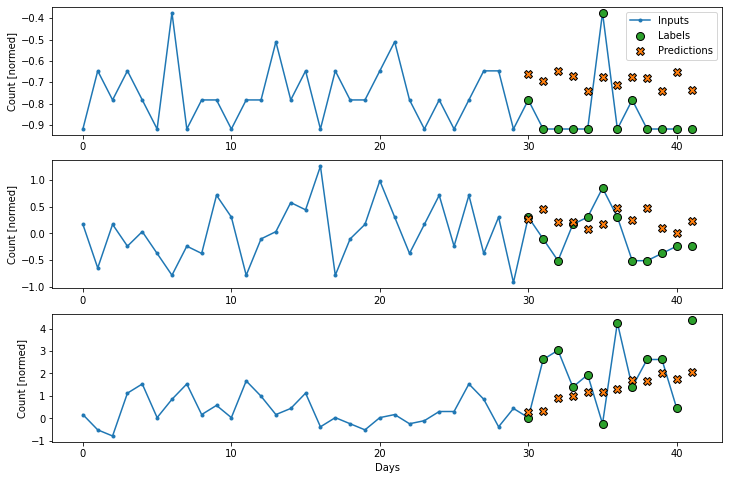

In [493]:
wide_conv_window.plot(conv_model)

# LSTM

In [494]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [495]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 30, 1)
Output shape: (32, 30, 1)


In [496]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

5/5 [==============================] - 0s 3ms/step - loss: 0.2237 - mean_absolute_error: 0.3913


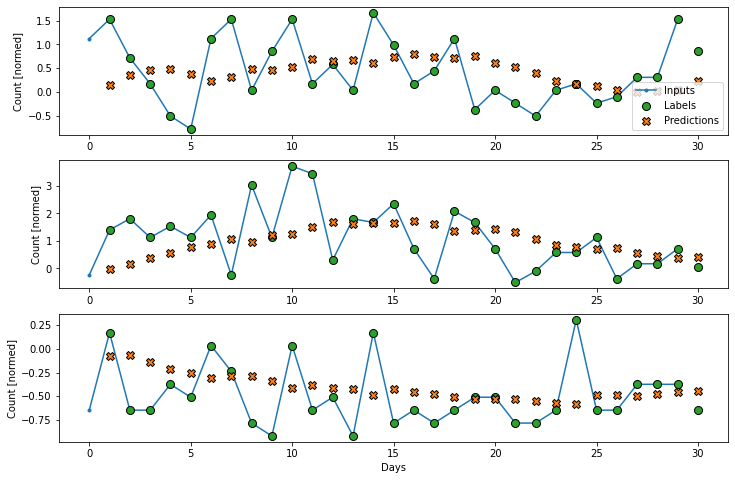

In [497]:
wide_window.plot(lstm_model)

# Residual LSTM
Instead of predicting the next value, predict the how the value will change in the next timestep. 

In [535]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [559]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, batch_size=128)
print()

5/5 [==============================] - 0s 3ms/step - loss: 0.2387 - mean_absolute_error: 0.3982

CPU times: user 9.09 s, sys: 586 ms, total: 9.68 s
Wall time: 7.11 s


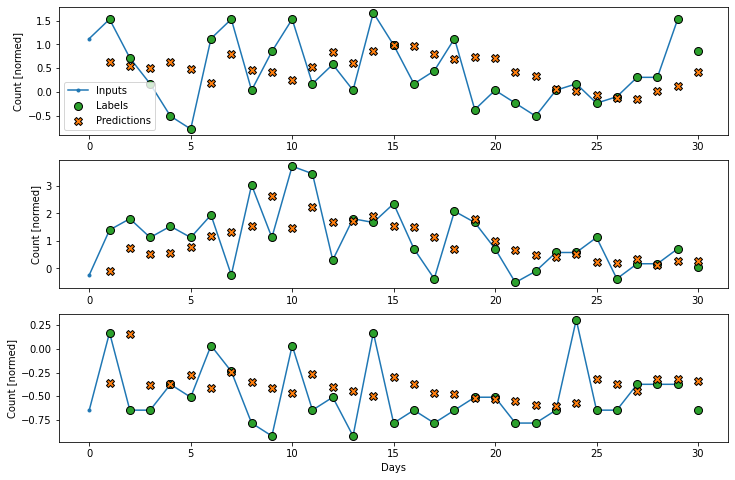

In [500]:
wide_window.plot(residual_lstm)

In [501]:
history

# Performance

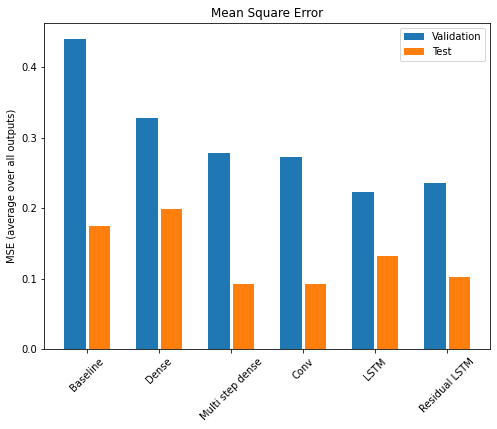

In [502]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_square_error'
metric_index = lstm_model.metrics_names.index('loss')
val_mse = [v[metric_index] for v in val_performance.values()]
test_mse = [v[metric_index] for v in performance.values()]

plt.title('Mean Square Error')
plt.bar(x - 0.17, val_mse, width, label='Validation')
plt.bar(x + 0.17, test_mse, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MSE (average over all outputs)')
_ = plt.legend()

In [503]:
model_l = []
mse_l = []
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')
  model_l.append(name)
  mse_l.append(value[1])

Baseline       : 0.1961
Dense          : 0.3780
Multi step dense: 0.1944
Conv           : 0.2302
LSTM           : 0.2834
Residual LSTM  : 0.2016


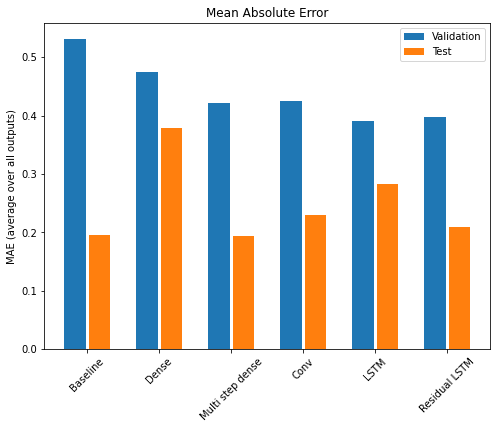

In [563]:
x = np.arange(len(performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.title('Mean Absolute Error')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [505]:
mae_l = []
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')
  mae_l.append(value[1])

Baseline       : 0.1961
Dense          : 0.3780
Multi step dense: 0.1944
Conv           : 0.2302
LSTM           : 0.2834
Residual LSTM  : 0.2016


In [506]:
performance_dt = pd.DataFrame([model_l, test_mse, test_mae]).T
performance_dt.columns = ['Model','MSE','MAE']
performance_dt

,Model,MSE,MAE
0,Baseline,0.175269,0.196091
1,Dense,0.19841,0.378032
2,Multi step dense,0.093252,0.194389
3,Conv,0.0930273,0.230151
4,LSTM,0.131856,0.283403
5,Residual LSTM,0.102951,0.201594


In [560]:
tf.saved_model.save(residual_lstm, 'residual_lstm')

INFO:tensorflow:Assets written to: residual_lstm/assets
